# American Option Pricing Project — Single Notebook

## Setup and assumptions

We work in the Black–Scholes–Merton framework:
- Under $Q$, the stock follows GBM: $dS_t = (r-q)S_t\,dt + \sigma S_t\,dW_t^{\mathbb{Q}}$
- Constant parameters $r,q,\sigma$ and frictionless market (no transaction costs)
- Prices are computed by risk-neutral expectation + discounting

Goal: price American options with
1) CRR binomial tree (benchmark, transparent)
2) Longstaff–Schwartz (LSM) Monte Carlo (scales well, approximate)


In [115]:
# =============================
# Libraries
# =============================

import numpy as np
from numpy.random import default_rng
from math import exp, log, sqrt, erf
import matplotlib.pyplot as plt
import pandas as pd

In [116]:
# =============================
# Global variables
# =============================

S0    = 100.0 # initial stock price
K     = 100.0 # strike price
r     = 0.05  # risk-free rate
q     = 0.00   # dividend yield (set q>0 to see early exercise for calls)
sigma = 0.20 # volatility
T     = 1.0 # time to maturity

seed  = 28 

In [117]:
# =============================
# Helpers
# =============================

def N_cdf(x):
    # Standard normal CDF using erf
    x = float(x)
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def payoff(S, K, opt="put"): 
    # Payoff function for European options
    
    if opt == "call":
        return np.maximum(S - K, 0.0)
    elif opt == "put":
        return np.maximum(K - S, 0.0)
    else:
        raise ValueError("opt must be 'call' or 'put'")

def mean_se(x):
    # Compute mean and standard error of array x
    
    if x.size < 2:
        return float(x.mean()), np.nan
    x = np.asarray(x, dtype=float)
    m  = float(x.mean())
    se = float(x.std(ddof=1) / sqrt(x.size))
    return m, se

def simulate_gbm_paths_exact(S0, r, q, sigma, T, m, n_paths, seed=0):
    # Exact discretization of GBM under Q:

    rng = default_rng(seed)
    dt = T / m
    drift = (r - q - 0.5 * sigma * sigma) * dt
    vol   = sigma * sqrt(dt)

    S = np.empty((m+1, n_paths), dtype=float)
    S[0, :] = S0
    for t in range(m):
        Z = rng.standard_normal(n_paths)
        S[t+1, :] = S[t, :] * np.exp(drift + vol * Z)
    return S


## European Black–Scholes price

For q = 0, an American call should equal the European call (no early exercise). Hence it is for validation only.


In [118]:
def bs_european_price(S0, K, r, q, sigma, T, opt="call"):
    if T <= 0:
        return float(payoff(np.array([S0]), K, opt=opt)[0])
    
    # Black-Scholes formula
    d1 = (log(S0 / K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    if opt == "call":
        return S0*exp(-q*T)*N_cdf(d1) - K*exp(-r*T)*N_cdf(d2)
    elif opt == "put":
        return K*exp(-r*T)*N_cdf(-d2) - S0*exp(-q*T)*N_cdf(-d1)
    else:
        raise ValueError("opt must be 'call' or 'put'")


## Section 1 — CRR binomial tree

We build a recombining CRR tree with
$u=e^{\sigma\sqrt{\Delta t}}$, $d=1/u$, and risk-neutral probability
$p=\frac{e^{(r-q)\Delta t}-d}{u-d}$.

Pricing is done by backward induction:
at each node we take the maximum between
- exercise now (intrinsic value)
- continue (discounted risk-neutral expectation)

Output:
- American call/put price at $t=0$
- Early-exercise boundary (useful to visualize exercise region)

Backward induction:

$$
V_{i,j}
=
\max\left(
g(S_{i,j}),
e^{-r\Delta t}\left[p\,V_{i+1,j+1}+(1-p)\,V_{i+1,j}\right]
\right)
$$

Notes:
- $V_{i,j}$: option value at node $(i,j)$
- $S_{i,j}$: stock price at node $(i,j)$
- $g(S)$: payoff if we exercise now (call $(S-K)^+$, put $(K-S)^+$)
- $\Delta t=T/N$, discount $e^{-r\Delta t}$
- $p$: risk-neutral prob. of an up move
- $r$ is the rate, $q$ dividend yield, $\sigma$ volatility.



In [119]:
def american_binomial_crr(S0, K, r, q, sigma, T, n_steps, opt="put", return_boundary=True):
    dt   = T / n_steps # time step 
    u    = exp(sigma * sqrt(dt)) # up factor
    d    = 1 / u # down factor
    disc = exp(-r * dt)    # discount factor
    a    = exp((r - q) * dt) # growth factor
    p    = (a - d) / (u - d) # risk-neutral up probability

    if p < -1e-10 or p > 1 + 1e-10:
        raise ValueError(f"Invalid p={p:.6g}. Increase n_steps or check parameters.")

    # Terminal stock prices
    j = np.arange(n_steps + 1) # number of up moves
    S = S0 * (u ** j) * (d ** (n_steps - j)) # stock prices at maturity
    V = payoff(S, K, opt=opt) # option values at maturity
 
    boundary = np.full(n_steps + 1, np.nan) if return_boundary else None

    # Backward induction
    for i in range(n_steps - 1, -1, -1): 
        V = disc * (p * V[1:i+2] + (1-p) * V[0:i+1]) # continuation value

        j = np.arange(i + 1) # number of up moves at time i
        S = S0 * (u ** j) * (d ** (i - j)) # stock prices at time i
        ex = payoff(S, K, opt=opt) # immediate exercise value

        ex_now = ex > V # paths where immediate exercise is better
        V = np.maximum(V, ex) # update option values

        if return_boundary:
            if ex_now.any():
                if opt == "put":
                    boundary[i] = float(S[ex_now].max())  # exercise when S below boundary
                else:
                    boundary[i] = float(S[ex_now].min())  # exercise when S above boundary
            else:
                boundary[i] = np.nan

    return float(V[0]), boundary


In [120]:
# Price with tree
tree_steps = 500 # time steps
am_put_tree, put_boundary = american_binomial_crr(S0, K, r, q, sigma, T, tree_steps, opt="put")
am_call_tree, call_boundary = american_binomial_crr(S0, K, r, q, sigma, T, tree_steps, opt="call")

print("CRR tree steps:", tree_steps)
print("American PUT  (tree):", am_put_tree)
print("American CALL (tree):", am_call_tree)


CRR tree steps: 500
American PUT  (tree): 6.088810110703037
American CALL (tree): 10.44658513644654


## Exercise boundary plot

From the tree we can extract an approximate exercise boundary:
- Put: exercise is optimal mainly when $S$ is low, so we record a threshold $S^*(t)$ such that exercise $\approx \{S \le S^*(t)\}$.
- Call with dividends: exercise can be optimal when $S$ is high, so boundary behaves like exercise $\approx \{S \ge S^*(t)\}$.

With $q=0$ the American call should show no early exercise (boundary mostly NaN/empty).



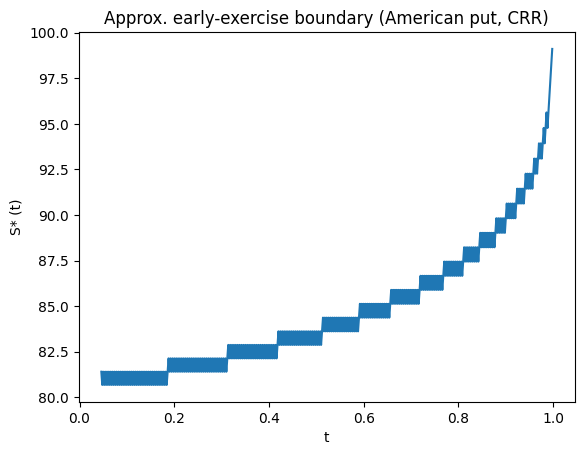

Call boundary is empty (no early exercise). With q=0, this is expected for an American call.


In [121]:
# Plot early-exercise boundaries from the CRR tree

t_grid = np.linspace(0.0, T, tree_steps + 1)

#Put boundary 
mask_put = np.isfinite(put_boundary)
plt.figure()
plt.plot(t_grid[mask_put], put_boundary[mask_put])
plt.title("Approx. early-exercise boundary (American put, CRR)")
plt.xlabel("t")
plt.ylabel("S* (t)")
plt.show()

# Call boundary 
mask_call = np.isfinite(call_boundary)
if mask_call.any():
    plt.figure()
    plt.plot(t_grid[mask_call], call_boundary[mask_call])
    plt.title("Approx. early-exercise boundary (American call, CRR)")
    plt.xlabel("t")
    plt.ylabel("S* (t)")
    plt.show()
else:
    print("Call boundary is empty (no early exercise). With q=0, this is expected for an American call.")


## Section 2 — Longstaff–Schwartz (LSM) Monte Carlo

LSM approximates the optimal stopping rule by regression.

At each time step (going backwards), for paths that are alive and in-the-money:
- compute immediate exercise value $g(S_t)$
- estimate continuation value $\hat C(S_t)$ by regressing discounted future cashflows on a basis

Here we use a simple quadratic basis in $x=S/K$:
$$
[1,\ x,\ x^2].
$$

Then we exercise when $g(S_t) \ge \hat C(S_t)$.
Finally, we discount the chosen cashflow to $t=0$ and average across paths (with SE and 95% CI).


In [122]:
def american_lsm(S0, K, r, q, sigma, T, m, n_paths, opt="put", seed=0):
    dt = T / m
    disc_step = exp(-r * dt)

    # Simulate paths (m+1, n_paths)
    S = simulate_gbm_paths_exact(S0, r, q, sigma, T, m, n_paths, seed=seed)

    # Cashflows: start with exercise at maturity
    tau = np.full(n_paths, m, dtype=int) # exercise times
    cf  = payoff(S[m, :], K, opt=opt)  # undiscounted cashflow at exercise time

    # Backward induction (exclude t=0 from regression, we handle t=0 at the end)
    for t in range(m-1, 0, -1): 

        alive = tau > t  # not exercised yet in backward sense
        St = S[t, :] # stock prices at time t
        ex = payoff(St, K, opt=opt) # immediate exercise value

        itm = alive & (ex > 0.0) # in-the-money paths
        if itm.sum() < 20: # not enough in-the-money paths
            continue

        # Discount current cashflow back to time t
        cont = cf * np.exp(-r * dt * (tau - t)) # continuation value

        x = St[itm] / K # normalized stock prices
        X = np.column_stack([np.ones_like(x), x, x*x])  # simple quadratic basis
        y = cont[itm] # target values

        beta, *_ = np.linalg.lstsq(X, y, rcond=None) # regression coefficients
        C_hat = X @ beta # continuation value estimates

        # exercise if immediate >= continuation estimate
        ex_now = ex[itm] >= C_hat # exercise now
        if ex_now.any(): 
            idx = np.flatnonzero(itm) # indices of in-the-money paths
            ex_idx = idx[ex_now] # indices of paths to exercise now
            tau[ex_idx] = t # update exercise times
            cf[ex_idx]  = ex[ex_idx] # immediate exercise value

    pv = cf * np.exp(-r * dt * tau) # present value of cashflows

    # Allow immediate exercise at t=0
    pv = np.maximum(pv, payoff(np.array([S0]), K, opt=opt)[0]) # present value including possible exercise at t=0

    price, se = mean_se(pv) # compute mean and standard error
    ci95 = (price - 1.96*se, price + 1.96*se) # 95% confidence interval
    return price, se, ci95, pv


In [123]:
# Price with LSM
lsm_steps = 50 # time steps
lsm_paths = 80000 # number of paths

am_put_lsm, se_put, ci_put, pv_put = american_lsm(S0, K, r, q, sigma, T, lsm_steps, lsm_paths, opt="put", seed=seed)
am_call_lsm, se_call, ci_call, pv_call = american_lsm(S0, K, r, q, sigma, T, lsm_steps, lsm_paths, opt="call", seed=seed)

print("LSM steps:", lsm_steps, "paths:", lsm_paths)
print(f"American put  (LSM): {am_put_lsm:.6f}   95% CI [{ci_put[0]:.6f}, {ci_put[1]:.6f}]")
print(f"American call (LSM): {am_call_lsm:.6f}   95% CI [{ci_call[0]:.6f}, {ci_call[1]:.6f}]")


LSM steps: 50 paths: 80000
American put  (LSM): 6.052314   95% CI [6.002930, 6.101697]
American call (LSM): 10.465845   95% CI [10.363565, 10.568124]


## Monte Carlo output diagnostics

Besides the price, we also look at the distribution of discounted payoffs.
A large mass at $0$ is normal: many paths finish out-of-the-money and produce zero payoff.

The reported standard error (SE) and 95% CI help quantify Monte Carlo uncertainty.
As the number of paths increases, SE should shrink roughly like $1/\sqrt{N}$.


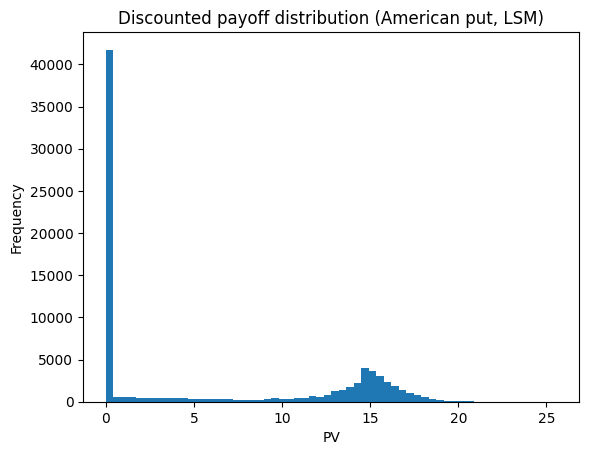

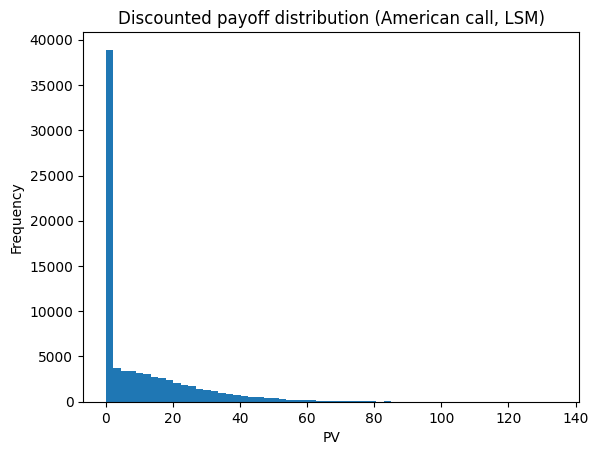

In [124]:
plt.figure()
plt.hist(pv_put, bins=60)
plt.title("Discounted payoff distribution (American put, LSM)")
plt.xlabel("PV")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(pv_call, bins=60)
plt.title("Discounted payoff distribution (American call, LSM)")
plt.xlabel("PV")
plt.ylabel("Frequency")
plt.show()


## Validation

Key check (theory): if $q=0$ (no dividends), an American call should not be exercised early, so:

- American call $\approx$ European call (Black–Scholes)

We compare:
- European call (BS closed form)
- American call via CRR tree
- American call via LSM

Small differences are expected due to discretization (tree) and Monte Carlo/regression noise (LSM).


In [125]:
euro_call = bs_european_price(S0, K, r, q, sigma, T, opt="call")
print("European call (BS):", euro_call)
print("American call (CRR tree):", am_call_tree)
print("American call (LSM):", am_call_lsm)


European call (BS): 10.450583572185565
American call (CRR tree): 10.44658513644654
American call (LSM): 10.465844696482618


## Convergence checks

Tree convergence:
- increase the number of steps $N$ and observe stabilization of prices

LSM convergence:
- increase number of paths $N_{\text{paths}}$ and observe smaller SE / tighter CI
- keep time steps $m$ fixed (exercise dates), so the method approximates a Bermudan option;
  increasing $m$ improves the approximation but may require more paths for stable regression.


In [126]:
# Convergence of the binomial tree prices as number of steps increases
steps_grid = [25, 50, 100, 200, 400, 800]
rows = []
for n in steps_grid:
    p_put, _ = american_binomial_crr(S0, K, r, q, sigma, T, n, opt="put", return_boundary=False)
    p_call, _ = american_binomial_crr(S0, K, r, q, sigma, T, n, opt="call", return_boundary=False)
    rows.append((n, p_put, p_call))

df_tree = pd.DataFrame(rows, columns=["steps", "AmPut_tree", "AmCall_tree"])
df_tree

,steps,AmPut_tree,AmCall_tree
0,25,6.146185,10.520966
1,50,6.073728,10.410692
2,100,6.082354,10.430612
3,200,6.086383,10.440591
4,400,6.088406,10.445586
5,800,6.089402,10.448084


In [127]:
# Convergence of the LSM prices as number of paths increases
paths_grid = [10_000, 30_000, 80_000, 200_000]
rows = []
for N in paths_grid:
    p, se_p, ci_p, _ = american_lsm(S0, K, r, q, sigma, T, m=lsm_steps, n_paths=N, opt="put", seed=seed)
    c, se_c, ci_c, _ = american_lsm(S0, K, r, q, sigma, T, m=lsm_steps, n_paths=N, opt="call", seed=seed)
    rows.append((N, p, se_p, ci_p[0], ci_p[1], c, se_c, ci_c[0], ci_c[1]))

df_lsm = pd.DataFrame(
    rows,
    columns=["paths", "AmPut_LSM", "SE_put", "CI_put_low", "CI_put_high",
             "AmCall_LSM", "SE_call", "CI_call_low", "CI_call_high"]
)
df_lsm

,paths,AmPut_LSM,SE_put,CI_put_low,CI_put_high,AmCall_LSM,SE_call,CI_call_low,CI_call_high
0,10000,6.103019,0.074028,5.957924,6.248114,10.363050,0.142371,10.084004,10.642097
1,30000,6.145679,0.042583,6.062216,6.229142,10.494364,0.085063,10.327640,10.661087
2,80000,6.052314,0.025196,6.002930,6.101697,10.465845,0.052183,10.363565,10.568124
3,200000,6.055193,0.016075,6.023686,6.086699,10.525056,0.033016,10.460344,10.589768


## Dividend yield example ($q>0$)

When $q>0$, holding the call option does not receive dividends.
This can make early exercise optimal, so:

- American call can be strictly greater than European call
- the tree boundary becomes non-empty (exercise-above threshold for the call)

We test this by setting a higher dividend yield and comparing BS (European) vs American (CRR and LSM).


q = 0.08
European call (BS): 6.142998472007754
American call (CRR tree): 6.5402594447287745
American call (LSM): 6.524411   95% CI [6.463260, 6.585561]


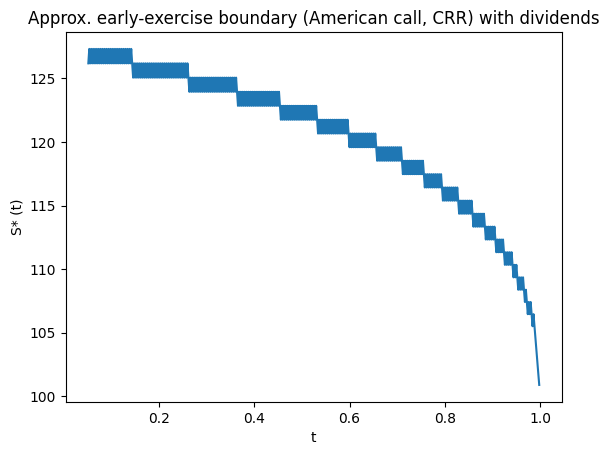

In [128]:
# Try a dividend yield example to see early exercise for calls
q_test = 0.08

am_call_tree_q, call_boundary_q = american_binomial_crr(S0, K, r, q_test, sigma, T, n_steps=500, opt="call")
am_call_lsm_q, se_call_q, ci_call_q, _ = american_lsm(S0, K, r, q_test, sigma, T, m=50, n_paths=80_000, opt="call", seed=seed)
euro_call_q = bs_european_price(S0, K, r, q_test, sigma, T, opt="call")

print("q =", q_test)
print("European call (BS):", euro_call_q)
print("American call (CRR tree):", am_call_tree_q)
print(f"American call (LSM): {am_call_lsm_q:.6f}   95% CI [{ci_call_q[0]:.6f}, {ci_call_q[1]:.6f}]")

t_grid = np.linspace(0.0, T, 501)
plt.figure()
plt.plot(t_grid, call_boundary_q)
plt.title("Approx. early-exercise boundary (American call, CRR) with dividends")
plt.xlabel("t")
plt.ylabel("S* (t)")
plt.show()


## Summary / conclusions

- CRR tree gives a clear and interpretable benchmark for American pricing and early exercise.
- LSM Monte Carlo is flexible and can handle more complex payoffs, but it is approximate and depends on:
  number of paths, number of exercise dates, and choice of regression basis.
- Validation passed: with $q=0$, American call prices from CRR/LSM are close to Black–Scholes.
- With $q>0$, early exercise for calls appears, consistent with theory.

Overall: both methods agree qualitatively and (with enough steps/paths) quantitatively.
